# ML to find radial velocities using FIRE data

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.colors as colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import sys
import gzip
import matplotlib.gridspec as gridspec

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
data = np.load('StarsWithRadialVelocity.npy')

In [3]:
data_cols = ['l', 'b','ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity',
             'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
             'pmra_error', 'pmdec_error', 'parallax_error', 'radial_velocity_error',
             'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error',
             'AccretedLabel'
            ]
#could train on radial_velocity_error

In [4]:
data = pd.DataFrame(data, columns=data_cols)

In [5]:
data.shape

(11400846, 19)

In [6]:
data.head()


,l,b,ra,dec,pmra,pmdec,parallax,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra_error,pmdec_error,parallax_error,radial_velocity_error,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,AccretedLabel
0,18.947771,17.087326,261.281075,-4.105546,0.304014,-2.012651,0.443537,44.472788,14.384683,14.678857,13.931516,0.091557,0.091557,0.044116,9.908263,0.000611,0.003929,0.003929,0.0
1,-4.978819,-41.542610,315.656827,-45.372252,15.768343,-16.975898,1.369992,-120.045033,12.405884,12.633657,12.030871,0.087001,0.087001,0.042780,2.036502,0.000342,0.002105,0.002105,0.0
2,-137.539419,-47.311996,60.814237,-25.789371,5.542696,9.388474,0.597262,83.063864,14.347357,14.619976,13.923520,0.091365,0.091365,0.044055,9.917098,0.000602,0.003861,0.003861,0.0
3,-68.315598,-32.353069,71.998054,-78.933526,14.320530,-13.669455,0.862436,-106.062495,14.062039,14.311761,13.648176,0.090130,0.090130,0.043668,7.792049,0.000544,0.003407,0.003407,0.0
4,85.879721,-52.988838,351.547535,3.638489,2.937268,5.109022,1.510236,-23.143291,14.677980,15.082906,14.107460,0.093275,0.093275,0.044678,11.110764,0.000683,0.004529,0.004529,0.0


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

In [8]:
# What columns to use?
use_cols = ['l', 'b','parallax','pmra','pmdec']
# Make the design matrix
X = data[use_cols].values
Y = (data['radial_velocity']).values
Y = (Y - np.mean(Y))/(np.std(Y))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X[1:500000], Y[1:500000],
                                                    test_size = 0.2,
                                                    random_state=42)


In [10]:
#trying to add some weights to training data
#might weight the mean, but no weights on confidence model? (something to think about)
vr_real = y_train
counts, bins = np.histogram(vr_real,bins=np.linspace(-620,620,51))
bin_centers = (bins[1:]+bins[:-1])/2
interp_func = interp1d(bin_centers,(counts).astype('float'))
inv_weights = interp_func(vr_real)
weights = 1/inv_weights
weights = np.log(weights)
weights = weights - np.min(weights)

In [11]:
print(X_train.shape)
print(y_train.shape)
print('There are {0} stars in the training set'.format(np.sum(y_train)))
print()
print(X_test.shape)
print(y_test.shape)
print('There are {0} stars in the test set'.format(np.sum(y_test)))

(399999, 5)
(399999,)
There are -216.34689720494123 stars in the training set

(100000, 5)
(100000,)
There are 67.51702782025998 stars in the test set


I think this is giving me a negative output because it's summing over y_train, which is not the number of stars, but is instead the radial velocities. 

In [12]:
SS = StandardScaler()
X_train = SS.fit_transform(X_train)

In [13]:
# Now scale the test data using the same mean and standard deviation as found with the training data
X_test = SS.transform(X_test)

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


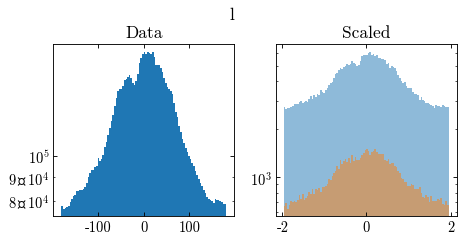

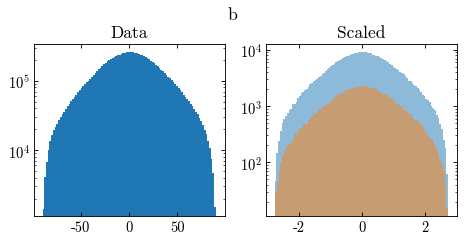

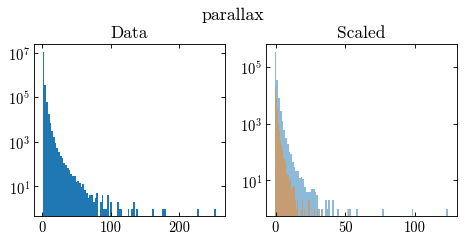

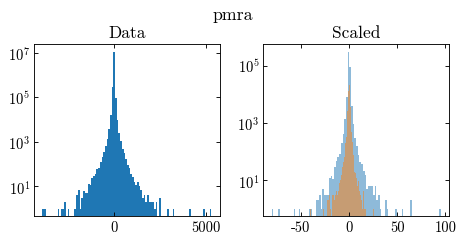

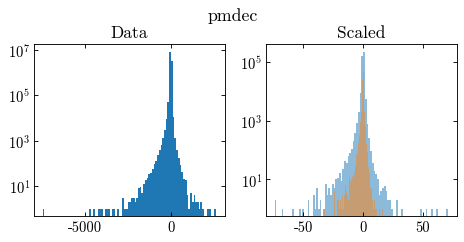

In [14]:
#visualize check data
for i, col in enumerate(use_cols):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.hist(data[col], bins=100)
    plt.yscale('log')
    plt.title('Data')
    
    plt.subplot(1,2,2)
    plt.hist(X_train[:, i], bins=100, alpha=0.5)
    plt.hist(X_test[:, i], bins=100, alpha=0.5)
    plt.yscale('log')
    plt.title('Scaled')
    
    plt.suptitle(col, y=1.01, fontsize=16)
    
    plt.tight_layout()

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [16]:
from keras import backend as K
from keras import callbacks as callbacks

In [17]:
class PlotLosses(callbacks.callbacks.Callback):
    def on_train_begin(self,logs = {}):
        self.i = 0
        self.train_data = [X_train, y_train]
        #what happens when training begins, initializations
        self.targets = []  # collect y_true batches
        self.outputs = []
        
        self.fig = plt.figure()

    def on_epoch_end(self, epoch, logs={}):
        self.i += 1
        if self.i % 2 == 0:
            #what happens during each epoch
            x_train, y_train = self.train_data
            self.targets = y_train
            prediction = self.model.predict(x_train)
            self.outputs = prediction

            clear_output(wait=True)
            plt.scatter(self.targets, self.outputs[:,0],color = 'blue', label = 'epoch '+str(self.i))
            plt.errorbar(self.targets, self.outputs[:,0], yerr = self.outputs[:,1], color = 'red', ls = 'none')
            x1 = np.linspace(-20,20,100)
            y1 = x1
            plt.plot(x1,y1,'k--')
            plt.xlim([-20, 20])
            plt.ylim([-20, 20])
            plt.ylabel('Vr predicted')
            plt.xlabel('Vr real')
            plt.legend()
            #plt.show();
            plt.savefig('error_images_try2/error_epoch_'+str(self.i)+'.png')
        
plot_losses = PlotLosses()

In [18]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1]) + 1e-9
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    #sigma = K.print_tensor(SIGMA, message='SIGMA = ')
    
    ARG = K.square(X - LOC) / (2 * K.square(SIGMA))
    K.print_tensor(ARG, message = 'ARG')
    K.print_tensor(K.pow(2 * np.pi * K.square(SIGMA), -0.5), message='input to PREFACT = ')
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    return K.mean(ARG - PREFACT)


In [19]:
#training any checkpoint or early stopping? 
es = EarlyStopping(patience=2, restore_best_weights=True)

In [20]:
def ConstantLikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    ARG = -K.square(X - LOC) / (2.0)
    return K.mean(-ARG)


Going to train once on Constant Likelihood first. 

In [20]:
MyModel = Sequential()
MyModel.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=2))
#using tanh activation function in the last layer
#MyModel.compile(loss='mean_squared_error',
               # optimizer='adam'
              # )
MyModel.compile(loss=ConstantLikelihoodLossFunction,
                optimizer='adam'
               )

In [21]:
MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 21,002
Trainable params: 21,002
Non-trainable params: 0
_________________________________________________________________


In [20]:
#training any checkpoint or early stopping? 
es = EarlyStopping(patience=2, restore_best_weights=True)

Not sure how long to train for at first...I just did 15 epochs because I'm concerned about overtraining?

In [ ]:
history = MyModel.fit(X_train,np.vstack([y_train,
                                  np.ones(y_train.shape[0])
                                  ]).T,
                      validation_split=0.2,
                      epochs=15,
                      batch_size=1000,
                      callbacks = [es]#,
                      #sample_weight=weights
                     )
#not sure exactly how many epochs I should run this for....we'll see 
#loss is still really small numbers- because of rescaling and then re-weighting

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Constant Loss Function')
plt.legend(['Train', 'Validation'])
plt.show()

Next going to train on Likelihood to get sigma 

In [25]:
MyModel.compile(loss=LikelihoodLossFunction,
                optimizer='adam'
               )

In [ ]:
history = MyModel.fit(X_train,np.vstack([y_train,
                                  np.ones(y_train.shape[0])
                                  ]).T,
                      validation_split=0.2,
                      epochs=300,
                      batch_size=1000,
                      callbacks = [es],
                      sample_weight=weights
                     )

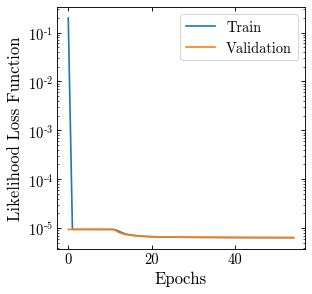

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Likelihood Loss Function')
plt.legend(['Train', 'Validation'])
plt.show()

In [26]:
# predict the scores for the test set, then histogram them based on the real labels
test_preds = MyModel.predict(X_test)

NameError: name 'MyModel' is not defined

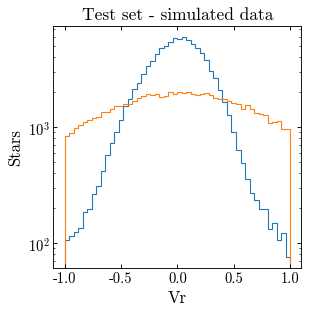

In [29]:
plt.hist(test_preds[:,0], bins=50, range=(-1,1), histtype='step')
plt.hist(y_test, bins=50, range=(-1,1), histtype='step')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.show()

[-0.79194146 -1.4480127  -0.8511834  ... -1.0518168  -0.7746358
 -0.7802698 ]


Text(0, 0.5, 'Error on Vr predicted')

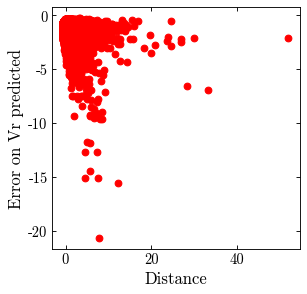

In [30]:
#test_preds[:,0] = (test_preds[:,0] - np.min(test_preds[:,0]))/(np.max(test_preds[:,0])- np.min(test_preds[:,0]))
#test_preds[:,1] = (test_preds[:,1] - np.min(test_preds[:,1]))/(np.max(test_preds[:,1])- np.min(test_preds[:,1]))
#y_test = (y_test - np.min(y_test))/(np.max(y_test)- np.min(y_test))
#manually normalizing output 
print(test_preds[:,1])
plt.scatter(X_test[:,2], test_preds[:,1], color = 'red')
#plt.errorbar(X_test[1:50,2], test_preds[1:50,0], yerr = test_preds[1:50,1], color = 'red',ls='none')
plt.xlabel('Distance')
plt.ylabel('Error on Vr predicted')

In [31]:
from scipy.interpolate import interpn
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

Text(0.5, 0, 'Vr real')

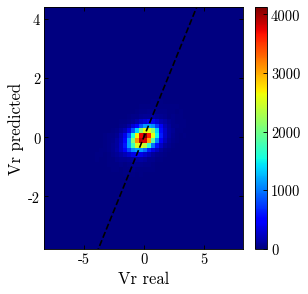

In [32]:
#plt.errorbar(y_test, test_preds[:,0], yerr = test_preds[:,1], color = 'red',ls='none')
#density_scatter(y_test, test_preds[:,0])
h = plt.hist2d(y_test, test_preds[:,0], (50, 50), cmap=plt.cm.jet)
plt.colorbar(h[3])

x = np.linspace(np.min(y_test),np.max(y_test),100)
y = x
plt.plot(x,y,'k--')
plt.ylabel('Vr predicted')
plt.xlabel('Vr real')

In [33]:
from scipy.stats import gaussian_kde
x = y_test
y = test_preds[:,0]
xy = np.vstack([y_test,test_preds[:,0]])
z = gaussian_kde(xy)(xy)



<ErrorbarContainer object of 3 artists>

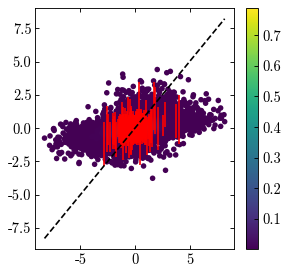

In [34]:
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x = y_test
y = test_preds[:,0]
x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
cax = ax.scatter(x, y, c=z, s=25, edgecolor='')
x1 = np.linspace(np.min(y_test),np.max(y_test),100)
y1 = x1
plt.plot(x1,y1,'k--')
fig.colorbar(cax)
plt.errorbar(y_test[600:800], test_preds[600:800,0], yerr = test_preds[600:800,1], color = 'red',ls='none')

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


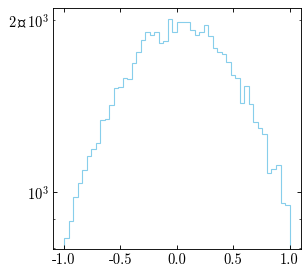

In [22]:
plt.hist(y_test, bins=50, range=(-1,1), histtype='step', color = 'skyblue', label = 'test' )
plt.yscale('log')

# Going to try the two network technique to calculate the error

In [21]:
from keras.layers import Input, Dense, Lambda, Concatenate
from keras.models import Model
from keras.utils import plot_model
from IPython.display import clear_output

In [22]:
# del(inputs, MeanEst, MeanModel, ConfEst, ConfModel)
inputs = Input(shape=(5,))
MeanEst = (Dense(100, activation='relu'))(inputs)
MeanEst = (Dense(100, activation='relu'))(MeanEst)
MeanEst = (Dense(100, activation='relu'))(MeanEst)
MeanEst = (Dense(1, activation='linear'))(MeanEst)
MeanModel = Model(inputs=[inputs], outputs=MeanEst)

ConfEst= (Dense(100, activation='relu'))(inputs)
ConfEst= (Dense(100, activation='relu'))(ConfEst)
ConfEst= (Dense(100, activation='relu'))(ConfEst)
ConfEst= (Dense(1, activation='relu'))(ConfEst)
ConfModel = Model(inputs=[inputs], outputs=ConfEst)
#how can this give me a confidence output? the only thing that appears to define a confidence is the relu
#on the last layer...think about this.
#CombinedSub = Concatenate(axis=-1)([MeanEst, ConfEst])
CombinedSub = Concatenate(axis=-1)([MeanModel(inputs), ConfModel(inputs)])

CombinedModel = Model(inputs=[inputs], outputs=CombinedSub)
#plot_model(CombinedModel,to_file='demo.png',show_shapes=True)

In [23]:
CombinedModel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            20901       input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            20901       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           model_1[1][0]                    
                                                                 model_2[1][0]              

In [25]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
#why does the loss only return not nan when I use this ...I'm guessing it has to do with the log...
CombinedModel.fit(X_train,y_train,
                  epochs=300,
                  batch_size=2000,
                  validation_split=0.2,
                  callbacks = [es],
                  sample_weight=weights
                 )

Train on 319999 samples, validate on 80000 samples
Epoch 1/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0046 - val_loss: 0.0045
Epoch 2/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0046 - val_loss: 0.0045
Epoch 3/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 4/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 5/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 6/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 7/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 8/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 9/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0044 - val

In [26]:
print(X_train[1:10])

[[ 0.08085497  0.26545354 -0.54544352  0.11028065  0.31528519]
 [ 0.59748615 -1.2092143  -0.53949586 -0.31288578  0.13258272]
 [ 0.43950856  1.88777805  1.15934962  0.04422229  0.62951318]
 [-0.28178545  0.43229284 -0.3067026  -1.55550154 -0.01426994]
 [-0.24668185 -0.9326447   0.37834052 -0.82540048  1.10382586]
 [-1.30194525 -1.12726005 -0.41005272  0.14716455  0.11326637]
 [-0.07283854  1.19363307  0.38744391  0.60898864  0.57432658]
 [-1.15999285  0.6639888  -0.33853958 -0.45678137  0.50984451]
 [-1.2690357  -1.11885634 -0.31431475 -0.19495264  0.68518749]]


In [27]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

CombinedModel.fit(X_train,y_train,
                  epochs=100,
                  batch_size=1000,
                  validation_split=0.2,
                  #callbacks = [plot_losses],
                  sample_weight=weights
                 )

Train on 319999 samples, validate on 80000 samples
Epoch 1/100
319999/319999 [==============================] - 2s 7us/step - loss: 14535113687907.0742 - val_loss: 0.0151
Epoch 2/100
319999/319999 [==============================] - 2s 6us/step - loss: 0.0148 - val_loss: 0.0146
Epoch 3/100
319999/319999 [==============================] - 2s 6us/step - loss: 0.0144 - val_loss: 0.0142
Epoch 4/100
319999/319999 [==============================] - 2s 6us/step - loss: 0.0140 - val_loss: 0.0139
Epoch 5/100
319999/319999 [==============================] - 2s 6us/step - loss: 0.0138 - val_loss: 0.0138
Epoch 6/100
319999/319999 [==============================] - 2s 6us/step - loss: 0.0138 - val_loss: 0.0138
Epoch 7/100
319999/319999 [==============================] - 2s 6us/step - loss: 0.0137 - val_loss: 0.0138
Epoch 8/100
319999/319999 [==============================] - 2s 6us/step - loss: 0.0137 - val_loss: 0.0138
Epoch 9/100
319999/319999 [==============================] - 2s 6us/step - loss:

KeyboardInterrupt: 

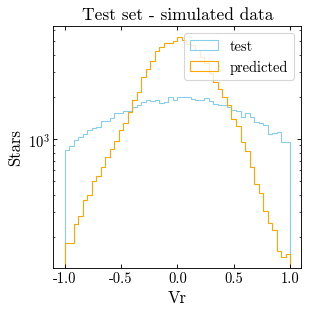

In [28]:
test_preds_2 = CombinedModel.predict(X_test)

plt.figure()
plt.hist(y_test, bins=50, range=(-1,1), histtype='step', color = 'skyblue', label = 'test' )
plt.hist(test_preds_2[:,0], bins=50, range=(-1,1), histtype='step',color = 'orange', label = 'predicted')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.legend(loc = "upper right")
plt.show()

In [29]:
np.any(np.isinf(test_preds_2[:,1]))

False

In [30]:
print(test_preds_2[1:10,:])

[[ 0.84018105  1.3900135 ]
 [-0.50664407  0.83972615]
 [-0.3030435   1.062593  ]
 [-0.09929561  0.85886145]
 [ 0.08756173  0.7529325 ]
 [-0.3335043   2.0482101 ]
 [-0.03259812  0.7256676 ]
 [-0.66080856  0.8721648 ]
 [-0.24156581  0.71830356]]


[1.3900135  0.83972615 1.062593   0.85886145 0.7529325  2.0482101
 0.7256676  0.8721648  0.71830356 0.70379996 1.2605551  0.7261983
 0.935355   0.65214014 0.9624739  0.87508714 0.7468368  1.3075086
 0.86904985 0.650145   1.3296138  0.6783139  1.390078   0.86082816
 0.71944577 1.1965157  1.157376   0.84174603 0.8744443  0.70980084
 0.8414701  0.68230915 1.4875399  0.86175716 1.0273854  1.1090219
 0.829671   1.2531337  0.78379476 0.83688504 1.0659813  0.8153797
 0.62013775 0.6667691  0.82607234 3.7265983  0.82239395 0.6685136
 1.2980884 ]


Text(0, 0.5, 'Error on Vr predicted')

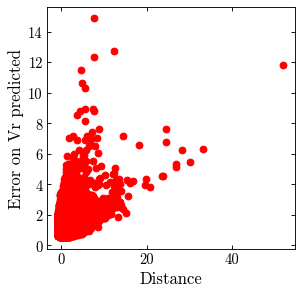

In [31]:
print(test_preds_2[1:50,1])
plt.scatter(X_test[:,2], test_preds_2[:,1], color = 'red')
#plt.errorbar(X_test[1:50,2], test_preds_2[1:50,0], yerr = test_preds_2[1:50,1], color = 'red',ls='none')
plt.xlabel('Distance')
plt.ylabel('Error on Vr predicted')
#does give a relu output...but I'm still not sure if this is exactly showing the error

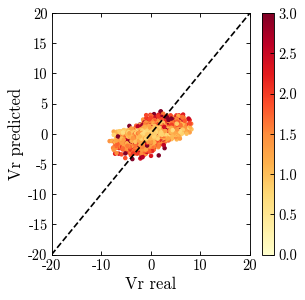

In [43]:
#plt.errorbar(y_test, test_preds_2[:,0], yerr = test_preds_2[:,1], color = 'red',ls='none')
sc = plt.scatter(y_test, test_preds_2[:,0], c =test_preds_2[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
x1 = np.linspace(-20,20,100)
y1 = x1
plt.plot(x1,y1,'k--')
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.ylabel('Vr predicted')
plt.xlabel('Vr real')
clb = plt.colorbar(sc)
plt.clim(0,3)

Should also do a density plot for this one. Also plot loss function for second method (will need to include output for .fit). 